In [40]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
from collections import Counter
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

## Importing dataset & Checking for missing data

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0

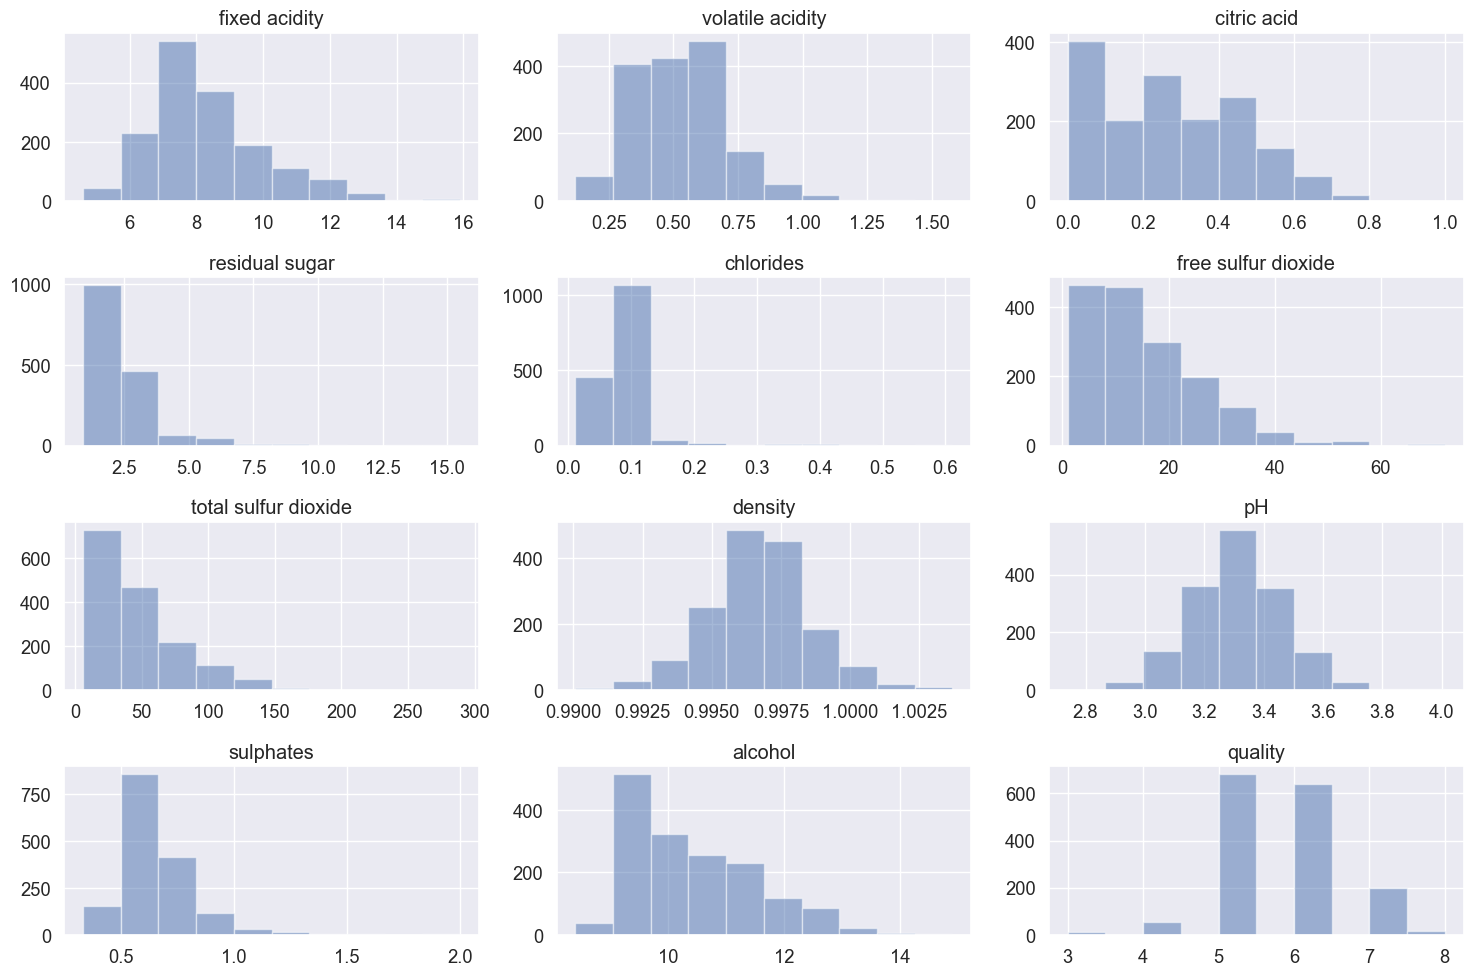


Checking for null values: 


Checking for null values after using fillna(): 



fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [41]:
headerList = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

wineData = pd.read_csv('winequality-red.csv', header = 0, names = headerList, sep=";")
print(wineData.head(10))
print(wineData)

#Summarative functions
wineData.dtypes
wineData.describe()
wineData.info()

#Plotting histogram of each variable
wineData.hist(alpha=0.5, figsize=(15, 10))
plt.tight_layout()
plt.show()

for h in headerList:
  wineData[h] = pd.to_numeric(wineData[h], errors='coerce')

print("\nChecking for null values: \n")
wineData.isna().sum()
wineData = wineData.fillna(0)
print("\nChecking for null values after using fillna(): \n")
wineData.isna().sum()


### Our data is imbalanced as seen from the histogram. We will adapt multiple strategies to address the issue.

# 2. Exploratory Data Analysis

## 1. Principal Component Analysis (PCA)

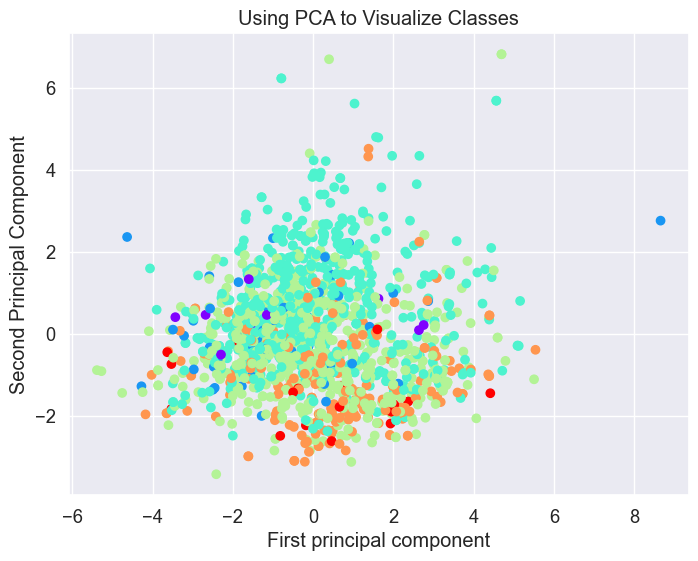

components:  [[ 0.48931422 -0.23858436  0.46363166  0.14610715  0.21224658 -0.03615752
   0.02357485  0.39535301 -0.43851962  0.24292133 -0.11323206]
 [-0.11050274  0.27493048 -0.15179136  0.27208024  0.14805156  0.51356681
   0.56948696  0.23357549  0.00671079 -0.03755392 -0.38618096]] 

explained variance:  [3.10107182 1.92711489] 

explained variance ratio:  [0.28173931 0.1750827 ]


In [42]:
#PCA
df_pca = wineData.copy()
X_pca = df_pca.loc[:, 'fixed acidity':'alcohol']
y_pca = df_pca['quality']

X_pca.tail()
X_pca = StandardScaler().fit_transform(X_pca)

#Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

X_pca.shape

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_pca,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title("Using PCA to Visualize Classes")
plt.show()

print("components: ", pca.components_, "\n")
print("explained variance: ", pca.explained_variance_, "\n")
exp_var_rat = pca.explained_variance_ratio_
print("explained variance ratio: ", exp_var_rat)

## 2. Correlation Matrix

<AxesSubplot:>

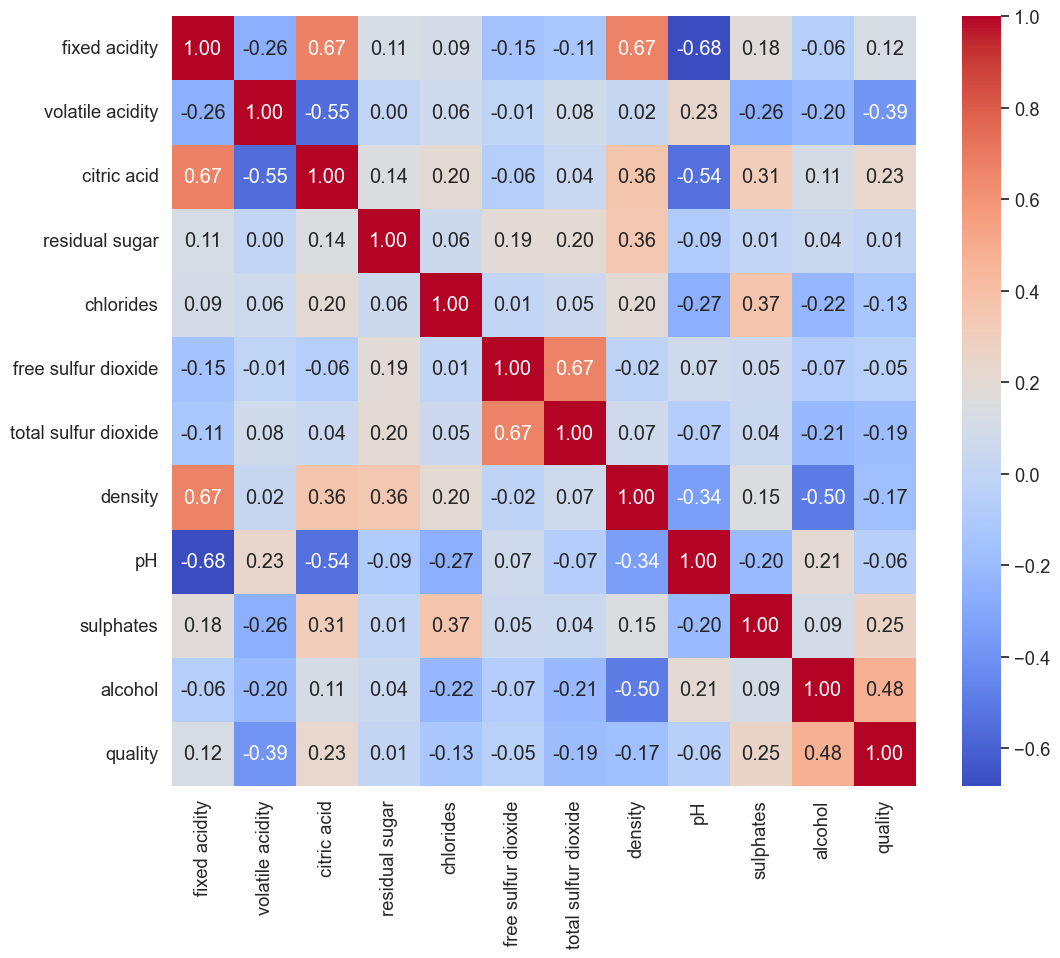

In [43]:
plt.figure(figsize=(12,10))
sns.heatmap(wineData.corr(),annot=True, cmap='coolwarm',fmt='.2f')

## 3. Univariate Selection

In [44]:
#Split data into training and test sets
X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']

# apply SelectKBest class to extract best features
bestFeatures = SelectKBest(score_func=chi2, k=11)
bestFeaturesFit = bestFeatures.fit(X,y)
dfscores = pd.DataFrame(bestFeaturesFit.scores_)
dfcolumns = pd.DataFrame(X.columns) 

# concatenate scores with predictor names
predScores = pd.concat([dfcolumns,dfscores],axis=1)
predScores.columns = ['Predictor','Score']
print(predScores.nlargest(11,'Score'))   

               Predictor        Score
6   total sulfur dioxide  2755.557984
5    free sulfur dioxide   161.936036
10               alcohol    46.429892
1       volatile acidity    15.580289
2            citric acid    13.025665
0          fixed acidity    11.260652
9              sulphates     4.558488
3         residual sugar     4.123295
4              chlorides     0.752426
8                     pH     0.154655
7                density     0.000230


## Dropping features from univariate selection

### We are dropping bottom features as they have very low predictor scores and to save computation

In [45]:
#save the original data
XOriginal = wineData.loc[:, 'fixed acidity':'alcohol']
yOriginal = wineData['quality']

#Drop the bottom three features (smallest score)
wineData = wineData.drop(['density'], axis=1)
wineData = wineData.drop(['pH'], axis=1)
wineData = wineData.drop(['chlorides'], axis=1)
print(wineData)

X = wineData.loc[:, 'fixed acidity':'alcohol']
y = wineData['quality']

      fixed acidity  volatile acidity  citric acid  residual sugar  \
0               7.4             0.700         0.00             1.9   
1               7.8             0.880         0.00             2.6   
2               7.8             0.760         0.04             2.3   
3              11.2             0.280         0.56             1.9   
4               7.4             0.700         0.00             1.9   
...             ...               ...          ...             ...   
1594            6.2             0.600         0.08             2.0   
1595            5.9             0.550         0.10             2.2   
1596            6.3             0.510         0.13             2.3   
1597            5.9             0.645         0.12             2.0   
1598            6.0             0.310         0.47             3.6   

      free sulfur dioxide  total sulfur dioxide  sulphates  alcohol  quality  
0                    11.0                  34.0       0.56      9.4        5  
1

In [46]:
#Create The Base Dataset
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE

# 1. Resized Data (less traits)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=10) #split the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape
scaledData = StandardScaler()
X_train = scaledData.fit_transform(X_train)
X_test = scaledData.transform(X_test)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(X_train, y_train, test_size = .2, random_state=11)

In [47]:
#Add in the Original Data set
# 2. Original Data (All traits) Using the same random state is essential to getting two identical matrices
X_train_Original, X_test_Original, y_train_Original, y_test_Original = train_test_split(XOriginal, yOriginal, test_size = .2, random_state=10) #split the data
X_train_Original.shape, y_train_Original.shape, X_test_Original.shape, y_test_Original.shape
scaledData = StandardScaler()
X_train_Original = scaledData.fit_transform(X_train_Original)
X_test_Original = scaledData.transform(X_test_Original)

# Addressing Imbalance in Class

## First Strategy: Oversampling minority class

In [48]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train_HP, y_train_HP)
print("Before RandomOverSampler : ", Counter(y_train_HP))
print("After RandomOverSampler : ", Counter(y_over))

Before RandomOverSampler :  Counter({5: 438, 6: 413, 7: 122, 4: 36, 8: 8, 3: 6})
After RandomOverSampler :  Counter({3: 438, 5: 438, 6: 413, 7: 122, 4: 36, 8: 8})


## Second Strategy: Undersampling majority class

In [49]:
smoteOversample = SMOTE()
X_smote, y_smote = smoteOversample.fit_resample(X_train_HP, y_train_HP)

#Plotting histogram of each variable (This broke for some reason)
# X_smote.hist(alpha=0.5, figsize=(15, 10))
#
# plt.tight_layout()
# plt.show()
#
# y_smote.hist(alpha=0.5, figsize=(15, 10))
# plt.show()

from collections import Counter
print("Before SMOTE : ", Counter(y_train_HP))
print("After SMOTE : ", Counter(y_smote))

Before SMOTE :  Counter({5: 438, 6: 413, 7: 122, 4: 36, 8: 8, 3: 6})
After SMOTE :  Counter({6: 438, 4: 438, 8: 438, 3: 438, 5: 438, 7: 438})


In [50]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train_HP, y_train_HP)
print("Before RandomUnderSampler : ", Counter(y_train_HP))
print("After RandomUnderSampler : ", Counter(y_under))

Before RandomUnderSampler :  Counter({5: 438, 6: 413, 7: 122, 4: 36, 8: 8, 3: 6})
After RandomUnderSampler :  Counter({6: 413, 7: 122, 4: 36, 8: 8, 3: 6, 5: 6})


## Third Strategy: SMOTE

## Fourth Strategy: Data Imputation
### Filling in data from missing classes - 0, 1, 2, 9, & 10 with fraud data

In [51]:
avgX = X.mean(axis=0)
dfImpute = pd.DataFrame(
                        [[avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 0], 
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 1],
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 2],
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 9],
                        [avgX[0], avgX[1], avgX[2], avgX[3], avgX[4], avgX[5], avgX[6], avgX[7], 10]],
                        columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol', 'quality']
                        )
dfImpute

X_add = dfImpute.loc[:, 'fixed acidity':'alcohol']
y_add = dfImpute['quality']
X_impute = pd.concat([X, X_add])
y_impute = pd.concat([y, y_add])

# 3. Comparing Machine Learning Models / Obtaining Baseline Accuracy

## Modeling - Final data preparations

In [52]:
def clas_report(X_train, y_train, x_test, y_test, model, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    sns.set(font_scale=1.2) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()
    clas = classification_report(y_test, y_pred)
    print(title, "\n",clas)

## 1. Random Forest Classifier

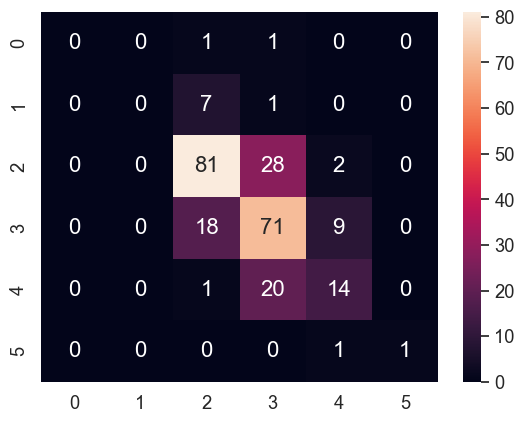

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.75      0.73      0.74       111
           6       0.59      0.72      0.65        98
           7       0.54      0.40      0.46        35
           8       1.00      0.50      0.67         2

    accuracy                           0.65       256
   macro avg       0.48      0.39      0.42       256
weighted avg       0.63      0.65      0.64       256



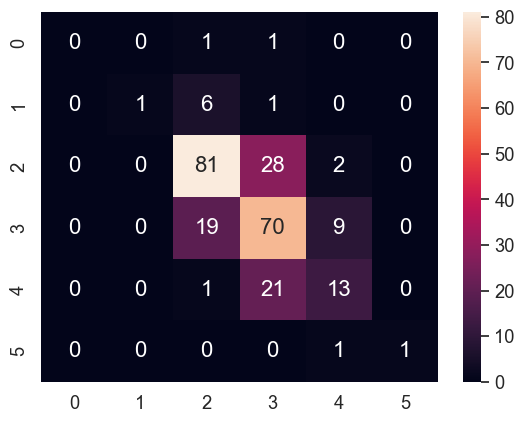

Oversampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.12      0.22         8
           5       0.75      0.73      0.74       111
           6       0.58      0.71      0.64        98
           7       0.52      0.37      0.43        35
           8       1.00      0.50      0.67         2

    accuracy                           0.65       256
   macro avg       0.64      0.41      0.45       256
weighted avg       0.66      0.65      0.64       256



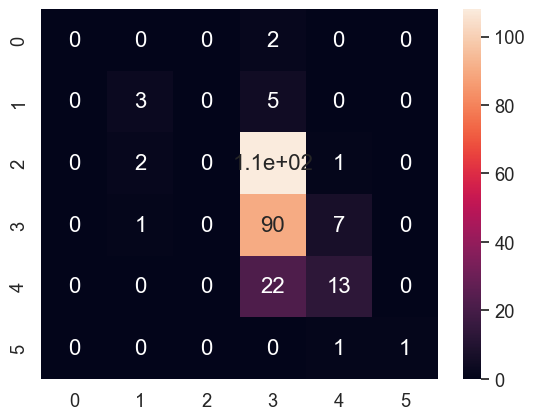

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.50      0.38      0.43         8
           5       0.00      0.00      0.00       111
           6       0.40      0.92      0.55        98
           7       0.59      0.37      0.46        35
           8       1.00      0.50      0.67         2

    accuracy                           0.42       256
   macro avg       0.41      0.36      0.35       256
weighted avg       0.26      0.42      0.29       256



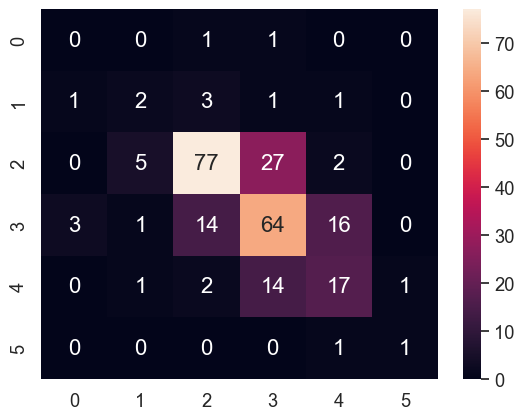

SMOTE Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.22      0.25      0.24         8
           5       0.79      0.69      0.74       111
           6       0.60      0.65      0.62        98
           7       0.46      0.49      0.47        35
           8       0.50      0.50      0.50         2

    accuracy                           0.63       256
   macro avg       0.43      0.43      0.43       256
weighted avg       0.65      0.63      0.64       256



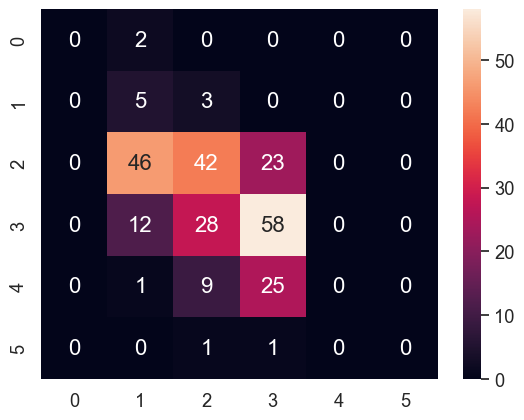

Imputed Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.08      0.62      0.14         8
           5       0.51      0.38      0.43       111
           6       0.54      0.59      0.57        98
           7       0.00      0.00      0.00        35
           8       0.00      0.00      0.00         2

    accuracy                           0.41       256
   macro avg       0.19      0.27      0.19       256
weighted avg       0.43      0.41      0.41       256



In [53]:
wineRF = RandomForestClassifier()
clas_report(X_train_HP, y_train_HP, X_test_HP, y_test_HP, wineRF, 'Regular Data')
clas_report(X_over, y_over, X_test_HP, y_test_HP, wineRF, 'Oversampled Data')
clas_report(X_under, y_under, X_test_HP, y_test_HP, wineRF, 'Undersampled Data')
clas_report(X_smote, y_smote, X_test_HP, y_test_HP, wineRF, 'SMOTE Data')
clas_report(X_impute, y_impute, X_test_HP, y_test_HP, wineRF, 'Imputed Data')

## 2. Support Vector Machine

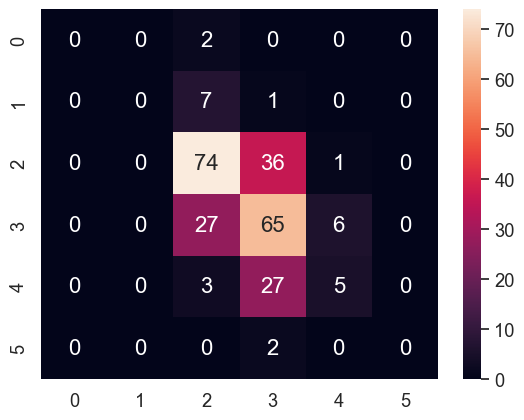

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.65      0.67      0.66       111
           6       0.50      0.66      0.57        98
           7       0.42      0.14      0.21        35
           8       0.00      0.00      0.00         2

    accuracy                           0.56       256
   macro avg       0.26      0.25      0.24       256
weighted avg       0.53      0.56      0.53       256



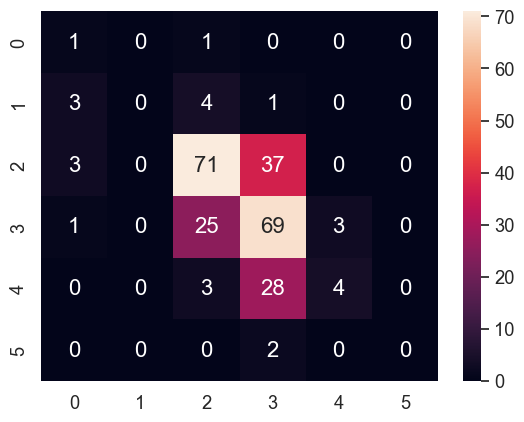

Oversampled Data 
               precision    recall  f1-score   support

           3       0.12      0.50      0.20         2
           4       0.00      0.00      0.00         8
           5       0.68      0.64      0.66       111
           6       0.50      0.70      0.59        98
           7       0.57      0.11      0.19        35
           8       0.00      0.00      0.00         2

    accuracy                           0.57       256
   macro avg       0.31      0.33      0.27       256
weighted avg       0.57      0.57      0.54       256



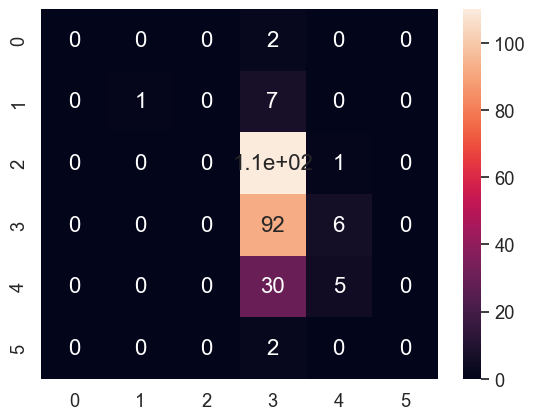

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.12      0.22         8
           5       0.00      0.00      0.00       111
           6       0.38      0.94      0.54        98
           7       0.42      0.14      0.21        35
           8       0.00      0.00      0.00         2

    accuracy                           0.38       256
   macro avg       0.30      0.20      0.16       256
weighted avg       0.23      0.38      0.24       256



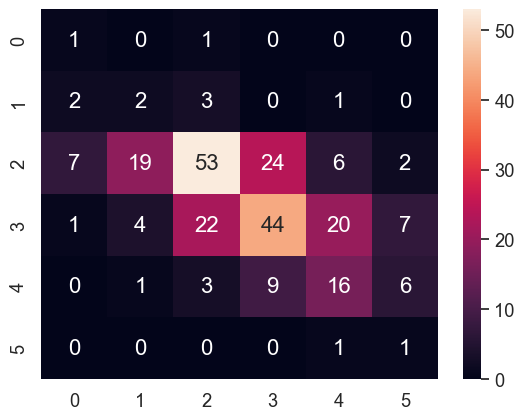

SMOTE Data 
               precision    recall  f1-score   support

           3       0.09      0.50      0.15         2
           4       0.08      0.25      0.12         8
           5       0.65      0.48      0.55       111
           6       0.57      0.45      0.50        98
           7       0.36      0.46      0.41        35
           8       0.06      0.50      0.11         2

    accuracy                           0.46       256
   macro avg       0.30      0.44      0.31       256
weighted avg       0.55      0.46      0.49       256



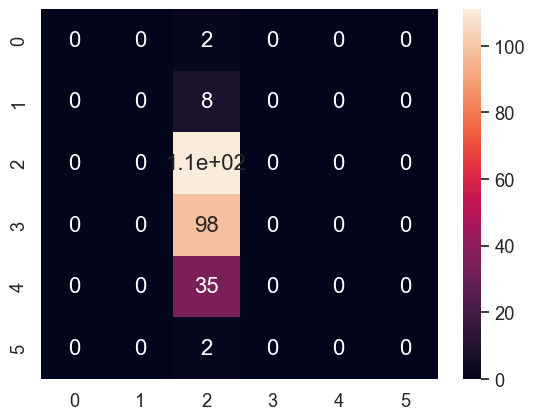

Imputed Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.43      1.00      0.60       111
           6       0.00      0.00      0.00        98
           7       0.00      0.00      0.00        35
           8       0.00      0.00      0.00         2

    accuracy                           0.43       256
   macro avg       0.07      0.17      0.10       256
weighted avg       0.19      0.43      0.26       256



In [54]:
wineSVM = SVC()
clas_report(X_train_HP, y_train_HP, X_test_HP, y_test_HP, wineSVM, 'Regular Data')
clas_report(X_over, y_over, X_test_HP, y_test_HP, wineSVM, 'Oversampled Data')
clas_report(X_under, y_under, X_test_HP, y_test_HP, wineSVM, 'Undersampled Data')
clas_report(X_smote, y_smote, X_test_HP, y_test_HP, wineSVM, 'SMOTE Data')
clas_report(X_impute, y_impute, X_test_HP, y_test_HP, wineSVM, 'Imputed Data')

## 3. Artificial Neural Network

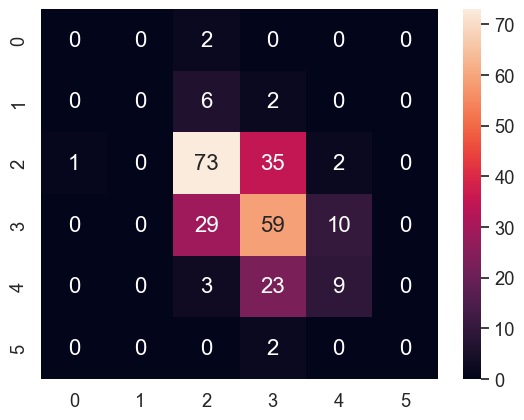

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.65      0.66      0.65       111
           6       0.49      0.60      0.54        98
           7       0.43      0.26      0.32        35
           8       0.00      0.00      0.00         2

    accuracy                           0.55       256
   macro avg       0.26      0.25      0.25       256
weighted avg       0.53      0.55      0.53       256



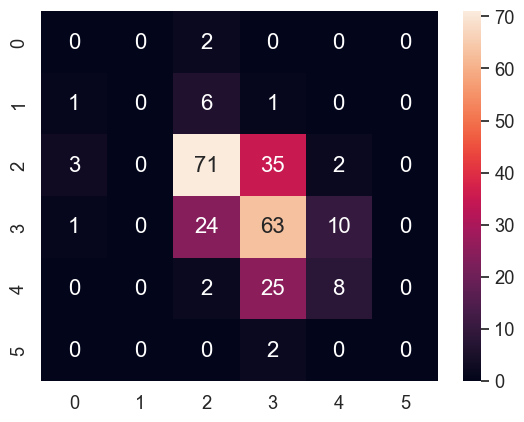

Oversampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.68      0.64      0.66       111
           6       0.50      0.64      0.56        98
           7       0.40      0.23      0.29        35
           8       0.00      0.00      0.00         2

    accuracy                           0.55       256
   macro avg       0.26      0.25      0.25       256
weighted avg       0.54      0.55      0.54       256



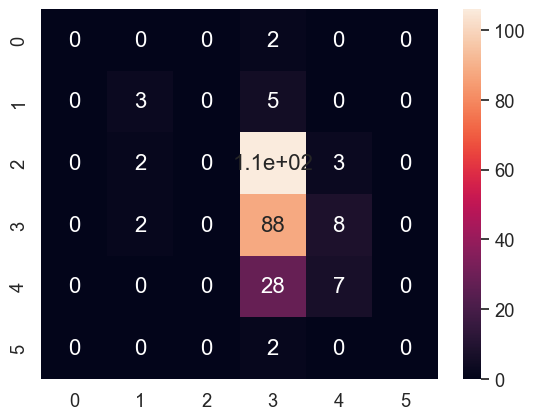

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.43      0.38      0.40         8
           5       0.00      0.00      0.00       111
           6       0.38      0.90      0.53        98
           7       0.39      0.20      0.26        35
           8       0.00      0.00      0.00         2

    accuracy                           0.38       256
   macro avg       0.20      0.25      0.20       256
weighted avg       0.21      0.38      0.25       256



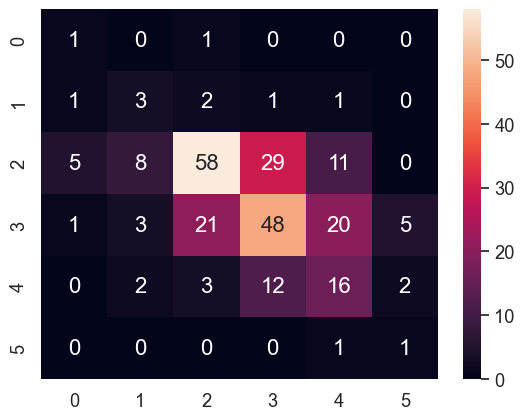

SMOTE Data 
               precision    recall  f1-score   support

           3       0.12      0.50      0.20         2
           4       0.19      0.38      0.25         8
           5       0.68      0.52      0.59       111
           6       0.53      0.49      0.51        98
           7       0.33      0.46      0.38        35
           8       0.12      0.50      0.20         2

    accuracy                           0.50       256
   macro avg       0.33      0.47      0.36       256
weighted avg       0.55      0.50      0.52       256



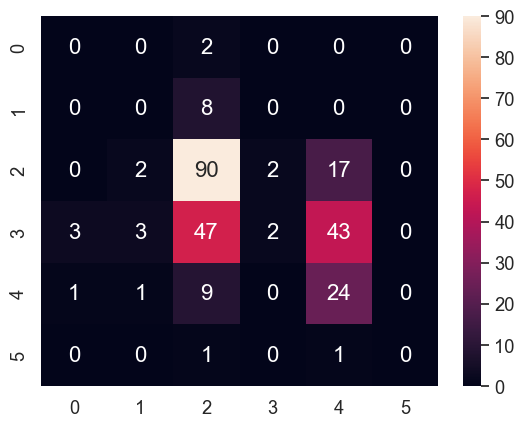

Imputed Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.57      0.81      0.67       111
           6       0.50      0.02      0.04        98
           7       0.28      0.69      0.40        35
           8       0.00      0.00      0.00         2

    accuracy                           0.45       256
   macro avg       0.23      0.25      0.19       256
weighted avg       0.48      0.45      0.36       256



In [55]:
wineMLP = MLPClassifier()
clas_report(X_train_HP, y_train_HP, X_test_HP, y_test_HP, wineMLP, 'Regular Data')
clas_report(X_over, y_over, X_test_HP, y_test_HP, wineMLP, 'Oversampled Data')
clas_report(X_under, y_under, X_test_HP, y_test_HP, wineMLP, 'Undersampled Data')
clas_report(X_smote, y_smote, X_test_HP, y_test_HP, wineMLP, 'SMOTE Data')
clas_report(X_impute, y_impute, X_test_HP, y_test_HP, wineMLP, 'Imputed Data')

## 4. Logistic Regression

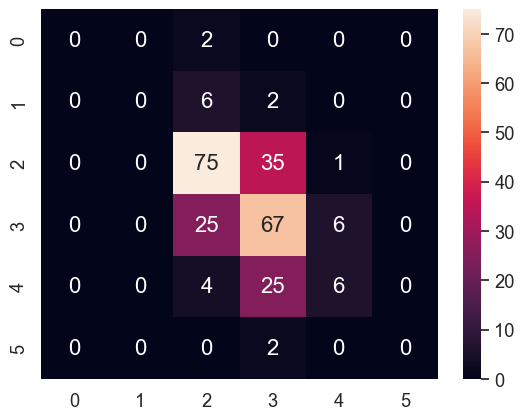

Regular Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.67      0.68      0.67       111
           6       0.51      0.68      0.59        98
           7       0.46      0.17      0.25        35
           8       0.00      0.00      0.00         2

    accuracy                           0.58       256
   macro avg       0.27      0.26      0.25       256
weighted avg       0.55      0.58      0.55       256



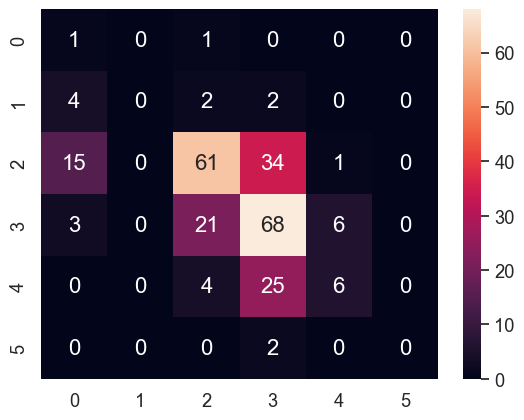

Oversampled Data 
               precision    recall  f1-score   support

           3       0.04      0.50      0.08         2
           4       0.00      0.00      0.00         8
           5       0.69      0.55      0.61       111
           6       0.52      0.69      0.59        98
           7       0.46      0.17      0.25        35
           8       0.00      0.00      0.00         2

    accuracy                           0.53       256
   macro avg       0.28      0.32      0.26       256
weighted avg       0.56      0.53      0.53       256



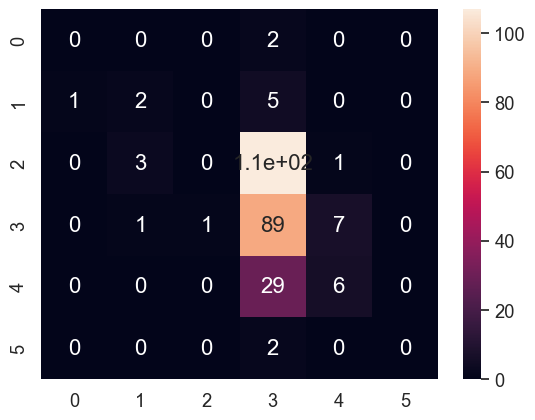

Undersampled Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.33      0.25      0.29         8
           5       0.00      0.00      0.00       111
           6       0.38      0.91      0.54        98
           7       0.43      0.17      0.24        35
           8       0.00      0.00      0.00         2

    accuracy                           0.38       256
   macro avg       0.19      0.22      0.18       256
weighted avg       0.21      0.38      0.25       256



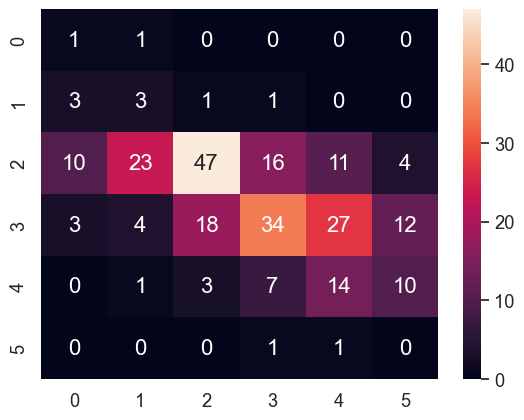

SMOTE Data 
               precision    recall  f1-score   support

           3       0.06      0.50      0.11         2
           4       0.09      0.38      0.15         8
           5       0.68      0.42      0.52       111
           6       0.58      0.35      0.43        98
           7       0.26      0.40      0.32        35
           8       0.00      0.00      0.00         2

    accuracy                           0.39       256
   macro avg       0.28      0.34      0.25       256
weighted avg       0.56      0.39      0.44       256



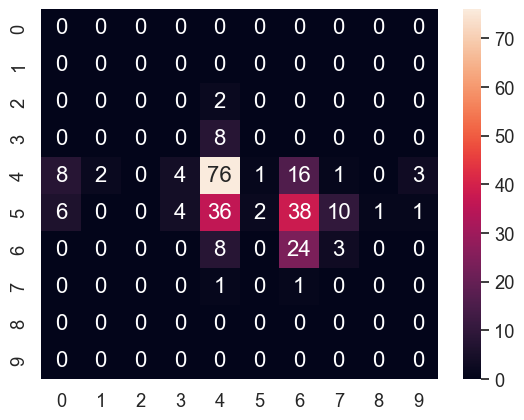

Imputed Data 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.58      0.68      0.63       111
           6       0.67      0.02      0.04        98
           7       0.30      0.69      0.42        35
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.40       256
   macro avg       0.16      0.14      0.11       256
weighted avg       0.55      0.40      0.35       256



In [56]:
wineLR = LogisticRegression()
clas_report(X_train_HP, y_train_HP, X_test_HP, y_test_HP, wineLR, 'Regular Data')
clas_report(X_over, y_over, X_test_HP, y_test_HP, wineLR, 'Oversampled Data')
clas_report(X_under, y_under, X_test_HP, y_test_HP, wineLR, 'Undersampled Data')
clas_report(X_smote, y_smote, X_test_HP, y_test_HP, wineLR, 'SMOTE Data')
clas_report(X_impute, y_impute, X_test_HP, y_test_HP, wineLR, 'Imputed Data')

# 4. Hyperparameter Tuning

## 1. Random Forest Classifier

### Manual GridSearch

#### Regular Data GridSearch

##### Note: These will likely take a very long time to run if you don't remove some of the hyper-parameters we tested here

In [57]:
#manual Grid Search (With Cut Features)
m_n_estimators = [20, 50, 75, 100, 200, 450, 700]
m_max_depth = [5,6,7,8, 15]
m_max_features = [.05, .1, .15, .2, .5, .8, 1]
m_max_samples = [.1, .2, .4, .6, .75, 1]
number_of_tests = len(m_n_estimators)*len(m_max_depth)*len(m_max_features)*len(m_max_samples)
hyper_parameter_matrix = np.zeros((number_of_tests, 5))
counter = 0

for f in m_max_features:
    for d in m_max_depth:
        for e in m_n_estimators:
            for s in m_max_samples:
                if f == 15:
                    wineRFC_HP = RandomForestClassifier(max_features=None, max_depth=d, n_estimators=e, max_samples=s, oob_score=True, random_state=417)
                else:
                    wineRFC_HP = RandomForestClassifier(max_features=f, max_depth=d, n_estimators=e, max_samples=s, oob_score=True, random_state=417)
                wineRFC_HP.fit(X_train_HP, y_train_HP)
                score = wineRFC_HP.score(X_test_HP, y_test_HP)
                score = np.round(score, 4)
                hyper_parameter_matrix[counter] = [f, d, e, s, score]
                counter += 1


#### Original Data Gridsearch

In [58]:
#manual Grid Search (Original Data)
m_n_estimators = [20, 50, 75, 100, 200, 450, 700]
m_max_depth = [4,6,8,15]
m_max_features = [.05, .1, .15, .2, .5, .8, 1]
m_max_samples = [.1, .2, .4, .6, .75, 1]
number_of_tests = len(m_n_estimators)*len(m_max_depth)*len(m_max_features)*len(m_max_samples)
hyper_parameter_matrix_Original = np.zeros((number_of_tests, 5))
X_HP_train_Original, X_HP_test_Original, y_HP_train_Original, y_HP_test_Original = train_test_split(X_train_Original, y_train_Original, test_size = .2, random_state=10) #split the data
counter = 0

for f in m_max_features:
    for d in m_max_depth:
        for e in m_n_estimators:
            for s in m_max_samples:
                if f == 15:
                    wineRFC_HP = RandomForestClassifier(max_features=None, max_depth=d, n_estimators=e, max_samples=s, oob_score=True, random_state=417)
                else:
                    wineRFC_HP = RandomForestClassifier(max_features=f, max_depth=d, n_estimators=e, max_samples=s, oob_score=True, random_state=417)
                wineRFC_HP.fit(X_HP_train_Original, y_HP_train_Original)
                score = wineRFC_HP.score(X_HP_test_Original, y_HP_test_Original)
                score = np.round(score, 4)
                hyper_parameter_matrix_Original[counter] = [f, d, e, s, score]
                counter += 1


#### Smote GridSearch

In [59]:
#manual Grid Search (Smote Data)
m_n_estimators = [20, 50, 75, 100, 200, 450, 700]
m_max_depth = [5,6,7,8, 15]
m_max_features = [.05, .1, .15, .2, .5, .8, 1]
m_max_samples = [.1, .2, .4, .6, .75, 1]
number_of_tests = len(m_n_estimators)*len(m_max_depth)*len(m_max_features)*len(m_max_samples)
hyper_parameter_matrix_Smote = np.zeros((number_of_tests, 5))
counter = 0

for f in m_max_features:
    for d in m_max_depth:
        for e in m_n_estimators:
            for s in m_max_samples:
                if f == 15:
                    wineRFC_HP = RandomForestClassifier(max_features=None, max_depth=d, n_estimators=e, max_samples=s, oob_score=True, random_state=417)
                else:
                    wineRFC_HP = RandomForestClassifier(max_features=f, max_depth=d, n_estimators=e, max_samples=s, oob_score=True, random_state=417)
                wineRFC_HP.fit(X_smote, y_smote)
                score = wineRFC_HP.score(X_test_HP, y_test_HP)
                score = np.round(score, 4)
                hyper_parameter_matrix_Smote[counter] = [f, d, e, s, score]
                counter += 1


### Find best Hyper Parameters for each model

#### Regular Data

In [75]:
best_HP = hyper_parameter_matrix[0]

for i in range(len(hyper_parameter_matrix)):
    if hyper_parameter_matrix[i][4] > best_HP[4]:
        # print(best_HP)
        best_HP = hyper_parameter_matrix[i]


print(best_HP)

[5.000e-02 1.500e+01 2.000e+02 7.500e-01 6.562e-01]


#### Original Data

In [76]:
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=10000)
# print(hyper_parameter_matrix_Original)
best_HP_Original = hyper_parameter_matrix_Original[0]

for i in range(len(hyper_parameter_matrix_Original)):
    if hyper_parameter_matrix_Original[i][4] > best_HP_Original[4]:
        # print(best_HP_Original)
        best_HP_Original = hyper_parameter_matrix_Original[i]

print(best_HP_Original)

[5.000e-02 1.500e+01 7.500e+01 7.500e-01 7.266e-01]


#### Smote Data

In [78]:
best_HP_Smote = hyper_parameter_matrix_Smote[0]

for i in range(len(hyper_parameter_matrix_Smote)):
    if hyper_parameter_matrix_Smote[i][4] > best_HP_Smote[4]:
        # print(best_HP_Smote)
        best_HP_Smote = hyper_parameter_matrix_Smote[i]

print(best_HP_Smote)

[5.000e-02 1.500e+01 7.500e+01 7.500e-01 7.266e-01]
[ 0.05   15.     50.      0.6     0.6328]
[ 0.05   15.     50.      0.6     0.6328]


### Vizualize hyper-parameter around local maxima for best performer (Original)

In [63]:
#creating hyper-parameter-matrices (Just for Original)
n_estimators_oop_matrix_2 = np.zeros((1,2))
max_depth_oop_matrix_2 = np.zeros((1,2))
max_features_oop_matrix_2 = np.zeros((1,2))
max_samples_oop_matrix_2 = np.zeros((1,2))

for i in hyper_parameter_matrix_Original:
    for j in range(0,4):
        HP_to_check = {0, 1, 2, 3}
        HP_to_check.remove(j)
        all_good=True
        for l in HP_to_check:
            if i[l] != best_HP_Original[l]:
                all_good=False
        if all_good:
            if j==0:
                max_features_oop_matrix_2 = np.append(max_features_oop_matrix_2,[[i[0], i[4]]], axis=0)
            elif j==1:
                max_depth_oop_matrix_2 = np.append(max_depth_oop_matrix_2 ,[[i[1], i[4]]], axis=0)
            elif j==2:
                n_estimators_oop_matrix_2 = np.append(n_estimators_oop_matrix_2 ,[[i[2], i[4]]], axis=0)
            elif j==3:
                max_samples_oop_matrix_2 = np.append(max_samples_oop_matrix_2 ,[[i[3], i[4]]], axis=0)

max_features_oop_matrix_Original = np.delete(max_features_oop_matrix_2, obj=0, axis=0)
max_depth_oop_matrix_Original = np.delete(max_depth_oop_matrix_2, obj=0, axis=0)
n_estimators_oop_matrix_Original = np.delete(n_estimators_oop_matrix_2, obj=0, axis=0)
max_samples_oop_matrix_Original = np.delete(max_samples_oop_matrix_2, obj=0, axis=0)

### Making the plots

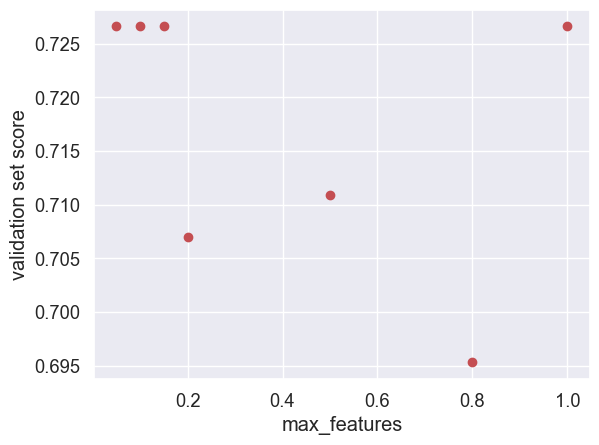

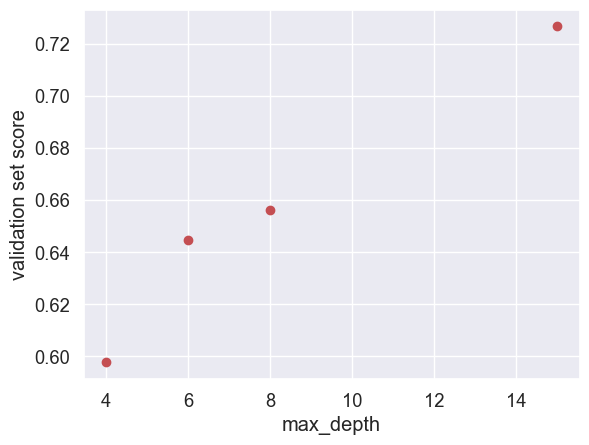

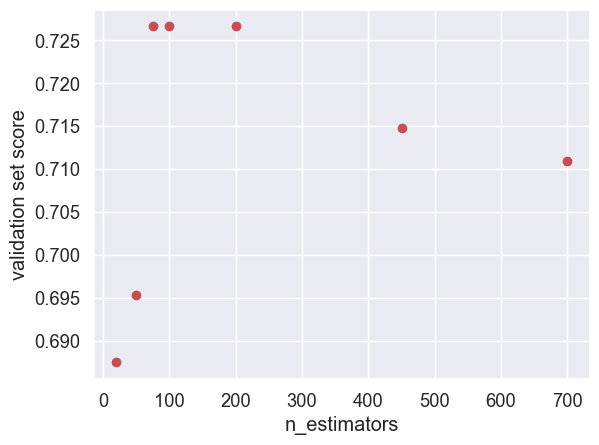

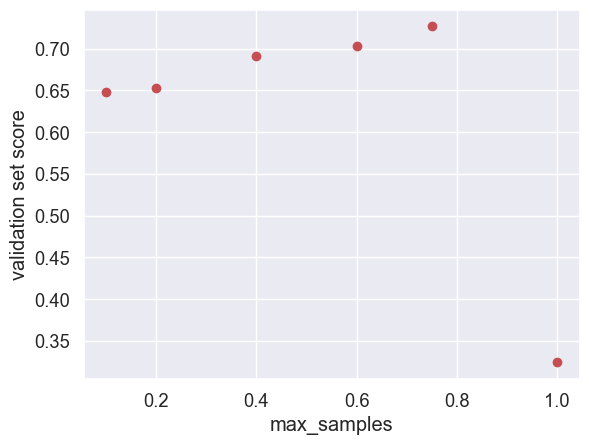

[5.000e-02 1.500e+01 7.500e+01 7.500e-01 7.266e-01]


In [64]:
plt.plot(max_features_oop_matrix_Original[:, 0],max_features_oop_matrix_Original[:, 1],'ro')
plt.xlabel('max_features')
plt.ylabel('validation set score')
plt.show()

plt.plot(max_depth_oop_matrix_Original[:, 0], max_depth_oop_matrix_Original[:, 1],'ro')
plt.xlabel('max_depth')
plt.ylabel('validation set score')
plt.show()

plt.plot(n_estimators_oop_matrix_Original[:, 0], n_estimators_oop_matrix_Original[:, 1], 'ro')
plt.xlabel('n_estimators')
plt.ylabel('validation set score')
plt.show()

plt.plot(max_samples_oop_matrix_Original[:, 0], max_samples_oop_matrix_Original[:, 1],'ro')
plt.xlabel('max_samples')
plt.ylabel('validation set score')
plt.show()

print(best_HP_Original)

In [65]:
def grid_search(X_train, y_train, model, param_grid, title):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    print(title, ": ", grid.best_params_)
    print("best score: ", grid.best_score_)

In [66]:
# wineRFC = RandomForestClassifier(random_state=417)
#
# param_grid_RFC = {
#     'n_estimators': [100, 200, 500, 1000],
#     'max_depth': [5,6,7,8],
# }
#
# grid_search(X_train, y_train, wineRFC, param_grid_RFC, 'Regular Data')
# grid_search(X_over, y_over, wineRFC, param_grid_RFC, 'Oversampled Data')
# grid_search(X_under, y_under, wineRFC, param_grid_RFC, 'Undersampled Data')
# grid_search(X_smote, y_smote, wineRFC, param_grid_RFC, 'SMOTE Data')
# grid_search(X_impute, y_impute, wineRFC, param_grid_RFC, 'Imputed Data')

## 2. Support Vector Machine

In [67]:
wineSVM = SVC()
param_grid_svm = {
    'kernel': ['rbf','sigmoid','poly'], 
    'C': [1, 10, 100, 1000]
}

grid_search(X_train_HP, y_train_HP, wineSVM, param_grid_svm, 'Regular Data')
grid_search(X_over, y_over, wineSVM, param_grid_svm, 'Oversampled Data')
grid_search(X_under, y_under, wineSVM, param_grid_svm, 'Undersampled Data')
grid_search(X_smote, y_smote, wineSVM, param_grid_svm, 'SMOTE Data')
grid_search(X_impute, y_impute, wineSVM, param_grid_svm, 'Imputed Data')

Regular Data :  {'C': 1, 'kernel': 'rbf'}
best score:  0.6067493872549019
Oversampled Data :  {'C': 10, 'kernel': 'rbf'}
best score:  0.7402061855670103
Undersampled Data :  {'C': 1, 'kernel': 'rbf'}
best score:  0.734354080615297
SMOTE Data :  {'C': 1000, 'kernel': 'rbf'}
best score:  0.8508383125113163
Imputed Data :  {'C': 1000, 'kernel': 'rbf'}
best score:  0.5710942367601245


## 3. Artificial Neural Network

In [68]:
wineANN = MLPClassifier(activation='logistic')
param_grid_ann = {
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 300, 500],
    'hidden_layer_sizes': [(10,), (100,), (300,)]
}

grid_search(X_train_HP, y_train_HP, wineANN, param_grid_ann, 'Regular Data')
grid_search(X_over, y_over, wineANN, param_grid_ann, 'Oversampled Data')
grid_search(X_under, y_under, wineANN, param_grid_ann, 'Undersampled Data')
grid_search(X_smote, y_smote, wineANN, param_grid_ann, 'SMOTE Data')
grid_search(X_impute, y_impute, wineANN, param_grid_ann, 'Imputed Data')

Regular Data :  {'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'max_iter': 300}
best score:  0.6122395833333333
Oversampled Data :  {'hidden_layer_sizes': (300,), 'learning_rate_init': 0.1, 'max_iter': 300}
best score:  0.7340206185567011
Undersampled Data :  {'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'max_iter': 300}
best score:  0.7394103404073494
SMOTE Data :  {'hidden_layer_sizes': (300,), 'learning_rate_init': 0.01, 'max_iter': 500}
best score:  0.865672279558211
Imputed Data :  {'hidden_layer_sizes': (300,), 'learning_rate_init': 0.001, 'max_iter': 500}
best score:  0.584797507788162


## 4. Logistic Regression

In [69]:
wineLR = LogisticRegression()
param_grid_lr = {
    'penalty' : ['l1', 'l2'],
    'solver':['lbfgs', 'liblinear','saga'],
    'max_iter': [100, 300, 500]
}

grid_search(X_train_HP, y_train_HP, wineLR, param_grid_lr, 'Regular Data')
grid_search(X_over, y_over, wineLR, param_grid_lr, 'Oversampled Data')
grid_search(X_under, y_under, wineLR, param_grid_lr, 'Undersampled Data')
grid_search(X_smote, y_smote, wineLR, param_grid_lr, 'SMOTE Data')
grid_search(X_impute, y_impute, wineLR, param_grid_lr, 'Imputed Data')

Regular Data :  {'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
best score:  0.6004993872549019
Oversampled Data :  {'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}
best score:  0.6982817869415807
Undersampled Data :  {'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
best score:  0.7140293405497792
SMOTE Data :  {'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}
best score:  0.5844823465507876
Imputed Data :  {'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
best score:  0.5748033489096572


# 5. Testing Final Models

In [70]:
def final_report(X_train, y_train, X_test, y_test, model, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(title, ": ", model.score(X_test, y_test))
    # clas = classification_report(y_pred, y_test)
    # print(clas)

## 1. Random Forest Classifier

0.7


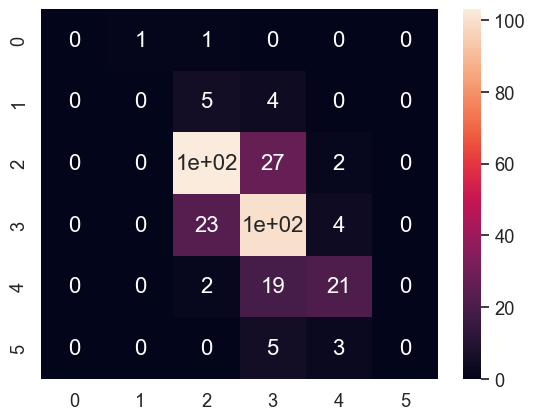

Final RFC W/ Original Data 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         9
           5       0.77      0.78      0.77       132
           6       0.65      0.79      0.71       127
           7       0.70      0.50      0.58        42
           8       0.00      0.00      0.00         8

    accuracy                           0.70       320
   macro avg       0.35      0.34      0.34       320
weighted avg       0.66      0.70      0.68       320



In [80]:
#True Final RFC model (the rest are for data analysis)
final_RFC = RandomForestClassifier(max_features=best_HP_Original[0], max_depth=int(best_HP_Original[1]), n_estimators=int(best_HP_Original[2]), max_samples=best_HP_Original[3] ,oob_score=True, random_state=417)
final_RFC.fit(X_train_Original, y_train_Original)
print(final_RFC.score(X_test_Original, y_test_Original))
clas_report(X_train_Original, y_train_Original, X_test_Original, y_test_Original, final_RFC, "Final RFC W/ Original Data")

In [71]:
wineRF_regular_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)
wineRF_over_final = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=417)
wineRF_under_final = RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=417)
wineRF_smote_final = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=417)
wineRF_impute_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=417)

final_report(X_train, y_train, X_test, y_test, wineRF_regular_final, 'Regular Data')
final_report(X_over, y_over, X_test, y_test, wineRF_over_final, 'Oversampled Data')
final_report(X_under, y_under, X_test, y_test, wineRF_under_final, 'Undersampled Data')
final_report(X_smote, y_smote, X_test, y_test, wineRF_smote_final, 'SMOTE Data')
final_report(X_impute, y_impute, X_test, y_test, wineRF_impute_final, 'Imputed Data')

Regular Data :  0.6375
Oversampled Data :  0.60625
Undersampled Data :  0.428125
SMOTE Data :  0.55
Imputed Data :  0.34375


## 2. Support Vector Machine

In [72]:
wineSVM_regular_final = SVC(kernel = 'rbf', C = 1)
wineSVM_over_final = SVC(kernel = 'rbf', C = 10)
wineSVM_under_final = SVC(kernel = 'rbf', C = 1)
wineSVM_smote_final = SVC(kernel = 'rbf', C = 1000)
wineSVM_impute_final = SVC(kernel = 'rbf', C = 1)

final_report(X_train, y_train, X_test, y_test, wineSVM_regular_final, 'Regular Data')
final_report(X_over, y_over, X_test, y_test, wineSVM_over_final, 'Oversampled Data')
final_report(X_under, y_under, X_test, y_test, wineSVM_under_final, 'Undersampled Data')
final_report(X_smote, y_smote, X_test, y_test, wineSVM_smote_final, 'SMOTE Data')
final_report(X_impute, y_impute, X_test, y_test, wineSVM_impute_final, 'Imputed Data')

Regular Data :  0.6
Oversampled Data :  0.60625
Undersampled Data :  0.421875
SMOTE Data :  0.5
Imputed Data :  0.4125


## 3. Artificial Neural Network

In [73]:
wineANN_regular_final = MLPClassifier(learning_rate_init=0.01, max_iter=100, hidden_layer_sizes=(100,))
wineANN_over_final = MLPClassifier(learning_rate_init=0.01, max_iter=500, hidden_layer_sizes=(300,))
wineANN_under_final = MLPClassifier(learning_rate_init=0.1, max_iter=100, hidden_layer_sizes=(100,))
wineANN_smote_final = MLPClassifier(learning_rate_init=0.01, max_iter=500, hidden_layer_sizes=(300,))
wineANN_impute_final = MLPClassifier(learning_rate_init=0.1, max_iter=300, hidden_layer_sizes=(300,))

final_report(X_train, y_train, X_test, y_test, wineANN_regular_final, 'Regular Data')
final_report(X_over, y_over, X_test, y_test, wineANN_over_final, 'Oversampled Data')
final_report(X_under, y_under, X_test, y_test, wineANN_under_final, 'Undersampled Data')
final_report(X_smote, y_smote, X_test, y_test, wineANN_smote_final, 'SMOTE Data')
final_report(X_impute, y_impute, X_test, y_test, wineANN_impute_final, 'Imputed Data')

Regular Data :  0.59375
Oversampled Data :  0.5875
Undersampled Data :  0.3875
SMOTE Data :  0.525
Imputed Data :  0.325


## 4. Logistic Regression

In [74]:
wineLR_regular_final = LogisticRegression(penalty='l2', solver= 'lbfgs', max_iter=100)
wineLR_over_final = LogisticRegression(penalty='l1', solver= 'saga', max_iter=100)
wineLR_under_final = LogisticRegression(penalty='l2', solver= 'lbfgs', max_iter=100)
wineLR_smote_final = LogisticRegression(penalty='l2', solver= 'lbfgs', max_iter=100)
wineLR_impute_final = LogisticRegression(penalty='l2', solver= 'lbfgs', max_iter=100)

final_report(X_train, y_train, X_test, y_test, wineLR_regular_final, 'Regular Data')
final_report(X_over, y_over, X_test, y_test, wineLR_over_final, 'Oversampled Data')
final_report(X_under, y_under, X_test, y_test, wineLR_under_final, 'Undersampled Data')
final_report(X_smote, y_smote, X_test, y_test, wineLR_smote_final, 'SMOTE Data')
final_report(X_impute, y_impute, X_test, y_test, wineLR_impute_final, 'Imputed Data')

Regular Data :  0.578125
Oversampled Data :  0.553125
Undersampled Data :  0.390625
SMOTE Data :  0.396875
Imputed Data :  0.3875
